In [1]:
# IMPORTS
import os, sys
from os.path import join, dirname, isdir, isfile, basename

SRC_PATH  = os.path.split(os.getcwd())[0]
if(not(SRC_PATH in sys.path)):
    sys.path.append(SRC_PATH)
CLASSIFIER_PATH = join(SRC_PATH,"model_classifier")
if(not(CLASSIFIER_PATH in sys.path)):
    sys.path.append(CLASSIFIER_PATH)
BOW_PATH = join(SRC_PATH,"bow_classifier")
if(not(BOW_PATH in sys.path)):
    sys.path.append(BOW_PATH)
    
from bow_classifier import *
from classify import *
from Random_Forest import Random_Forest
from Logistic_Regression import Logistic_Regression

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.tree import export_graphviz

import matplotlib.pyplot as plt
import itertools
import re, json, csv

import pydotplus 
from IPython.display import Image

In [3]:
# LOAD DATA
man_class_file = "/home/kai/Workspace/deep_doc_class/deep_doc_class/data/classification_with_category.csv"
man_class = pd.read_csv(man_class_file, delimiter=',', header=0, quoting=1)

train_doc_ids = list(man_class[man_class["train_doc"]==True]["doc_id"])
train_labels = list(man_class[man_class["train_doc"]==True]["class"])

test_doc_ids = list(man_class[man_class["train_doc"]==False]["doc_id"])
test_labels = list(man_class[man_class["train_doc"]==False]["class"])

features = ["filename",
            "folder_name",
            "creator",
            "producer",
            "bold_text",
            "first_100_words",
            "last_100_words"]

#train_doc_ids, train_labels = remove_bad_doc_ids(train_doc_ids, train_labels, false_docs+xml_error)
#test_doc_ids, test_labels = remove_bad_doc_ids(test_doc_ids, test_labels, false_docs+xml_error)

bc = BowClassifier("first_100_words")
clean_train_strings = bc.load_clean_data(train_doc_ids)
clean_test_strings = bc.load_clean_data(test_doc_ids)

In [4]:
# VECTORIZE DATA
def load_custom_words(wordspath):
    f = open(wordspath, 'r')
    words = f.read()
    f.close()
    vocab = re.split("\s",words)
    vocab = re.sub("\s"," ",words)
    vocab = vocab.split()
    return vocab

#count_vec = CountVectorizer(analyzer='word',token_pattern=r'(?u)\b\w\w\w+\b|©')
fidf_vec = TfidfVectorizer(token_pattern=r'(?u)\b\w\w\w+\b|©', min_df=1)
#custom_vec = CountVectorizer(vocabulary=load_custom_words(join(BOW_PATH,"words",bc.name+".txt")))

vectorizer = fidf_vec
vectorizer.fit(clean_train_strings)

train_data = vectorizer.transform(clean_train_strings).toarray()
test_data = vectorizer.transform(clean_test_strings).toarray()

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

41030


In [5]:
# FOREST
kwargs = {"n_estimators":1, "criterion":'entropy', "max_depth":30, "min_samples_split":2,
          "min_samples_leaf":5, "min_weight_fraction_leaf":0.0, "max_features":len(feature_names),
          "max_leaf_nodes":None, "min_impurity_split":1e-07, "bootstrap":False,
          "oob_score":False, "n_jobs":1, "random_state":None, "verbose":0, "warm_start":False,
          "class_weight":None}
rf = Random_Forest(**kwargs)

In [6]:
# LOGISTIC REGRESSION
kwargs = {"penalty":'l2', "C":100, "fit_intercept":True, "intercept_scaling":1, "class_weight":"balanced",
          "solver":"liblinear", "max_iter":10, "tol":0.01}
lr = Logistic_Regression(**kwargs)

train_acc: 0.966
total: 496
copyright: 155
not_protected: 0
auc_roc: 0.818
auc_pr: 0.484
acc: 0.851
f1: 0.753
precision: 0.779
recall: 0.729


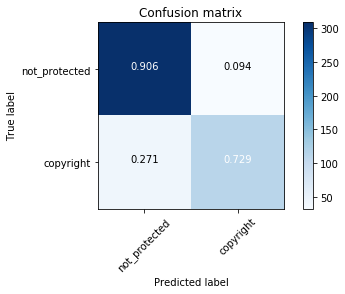

2014                                    -16.84255
2016                                    -14.37711
prof                                    -11.38466
osnabrück                               -10.14557
seminar                                 -9.97030
2015                                    -8.97901
universität                             -8.95058
sie                                     -8.91554
einführung                              -8.67438
gliederung                              -8.35001
fall                                    -8.15354
bgb                                     -7.98610
art                                     -7.84472
vorlesung                               -7.84381
was                                     -7.59926
thema                                   -7.45948
uos                                     -7.12341
aufgabe                                 -7.02986
der                                     -6.95508
dass                                    -6.45971
definition      

In [7]:
# CLASSIFY
classifier = lr
classifier.train(train_data, train_labels)

#classifier.model = joblib.load(join(BOW_PATH,"custom_log_reg",bc.name+".pkl"))

probs = classifier.predict_proba_binary(train_data)
preds = probs>0.5

print("train_acc: %.3f"%(accuracy_score(train_labels,preds),))

probs = classifier.predict_proba_binary(test_data)
preds = probs>0.5

print("total: %d"%(len(test_labels),))
print("copyright: %d"%(np.sum(test_labels),))
print("not_protected: %d"%(np.sum(test_labels==0),))

fpr, tpr, thresholds = roc_curve(test_labels, preds)
precision, recall, thresholds = precision_recall_curve(test_labels, preds)

print("auc_roc: %.3f"%(auc(fpr, tpr),))
print("auc_pr: %.3f"%(auc(precision, recall),))
print("acc: %.3f"%(accuracy_score(test_labels,preds),))
print("f1: %.3f"%(f1_score(test_labels,preds),))
print("precision: %.3f"%(precision_score(test_labels,preds),))
print("recall: %.3f"%(recall_score(test_labels,preds),))
plot_confusion_matrix(confusion_matrix(test_labels,preds),["not_protected","copyright"],True)

top_100_words = analyse_feature_ranking(classifier, feature_names, 100)
print(top_100_words)

In [31]:
tree = rf.model.estimators_[0]
dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=feature_names,  
                         class_names=["not_protected", "copyright"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  


IndexError: list index out of range

In [81]:
# PARAMETER COMBINATION
classifier = lr
comb_param_names = ["solver","C","max_iter","class_weight"]
comb_param_vals = [["sag","liblinear"],[1,10,100,500],[5,10,100],[None,"balanced"]]

if(not(isdir(join(BOW_PATH,"eval_results",bc.name)))):
    os.makedirs(join(BOW_PATH,"eval_results",bc.name))
results_file=join(BOW_PATH,"eval_results",bc.name,"logreg_tfidf_s_c_mi_cw.txt")
results = compare_parameter_combinations_bin(classifier, comb_param_names, comb_param_vals, train_data, train_labels,
                                             test_data, test_labels, results_file=results_file, save_model=False)

/home/kai/venvs/doc/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [14]:
#bc.analyze_word_distribution(clean_train_data, train_labels)

#übung_col = np.array([bool(re.search("(ue|ü| )bung ", text)) for text in clean_train_data])
#übung_col = np.array([bool(re.search("(ue|ü| )?bersicht ", text)) for text in clean_train_data])
#übung_col = np.array([bool(re.search("einf(ue|ü| )?hrung ", text)) for text in clean_train_data])
übung_col = np.array([bool(re.search(" [0-9]{4} pdf", text)) for text in clean_train_data])
übung_col = np.array([bool(re.search("pr(ae|ä| |e| 776 )sentation", text)) for text in clean_train_data])
übung_col = np.array([bool(re.search("(ue|ü| |( )?776 )bersicht", text)) for text in clean_train_data])
übung_col = np.array([bool(re.search("l(oe|ö| | 776 )sung ", text)) for text in clean_train_data])
übung_col = np.array([bool(re.search("review", text)) for text in clean_train_data])

#print(clean_test_data)
pos_cnt = np.sum(übung_col[train_labels==1])
neg_cnt = np.sum(übung_col[train_labels==0])
pos_perc = pos_cnt/np.sum(train_labels==1)
neg_perc = neg_cnt/np.sum(train_labels==0)
rel = max(pos_perc,neg_perc)/min(pos_perc,neg_perc) if min(pos_perc,neg_perc)>0 else 0
print(pos_perc,neg_perc,rel,pos_cnt,neg_cnt)

print("true")
fat = np.logical_and(train_labels==1,übung_col)
for i in range(len(clean_train_data)):
    if(fat[i]):
        print(clean_train_data[i])

print("\n")
print("false")
faf = np.logical_and(train_labels==0,übung_col)
for i in range(len(clean_train_data)):
    if(faf[i]):
        print(clean_train_data[i])

a = '''
einfuehrung
sitzung
übung
vorlesung
folien
session
präsentation
course
seminar
gruppe
handout
lösung
prüfung
tutorium
blatt
'''


0.0 0.0 0 0 0
true


false


In [ ]:
# should probably be balanced everywhere -> way better recall

first_100_words:{"penalty":'l2', "C":100, "fit_intercept":True, "intercept_scaling":1, "class_weight":"balanced",
          "solver":"liblinear", "max_iter":10, "tol":0.01}
last_100_words:{"penalty":'l2', "C":100, "fit_intercept":True, "intercept_scaling":1, "class_weight":"balanced",
          "solver":"liblinear", "max_iter":10, "tol":0.01}
creator:kwargs = {"penalty":'l2', "C":100, "fit_intercept":True, "intercept_scaling":1, "class_weight":None,
          "solver":"liblinear", "max_iter":10, "tol":0.01}
producer:kwargs = {"penalty":'l2', "C":100, "fit_intercept":True, "intercept_scaling":1, "class_weight":None,
          "solver":"liblinear", "max_iter":10, "tol":0.01}
bold:None
filename:kwargs = {"penalty":'l2', "C":100, "fit_intercept":True, "intercept_scaling":1, "class_weight":None,
      "solver":"liblinear", "max_iter":10, "tol":0.01}
folder_name:kwargs = {"penalty":'l2', "C":10, "fit_intercept":True, "intercept_scaling":1, "class_weight":None,
  "solver":"liblinear", "max_iter":100, "tol":0.01}